# Main Pairs Trading Project Notebook

##### Pairs Trading Basic Strategy:
- Find 2 assets that move similarly with eachother
- Sell the 'overvalued' stock and buy the 'undervalued' stock using the Price Ratio (Stock A / Stock B). If the ratio changes significantly, then it is time to trade. 'Significance' can be measured with standard deviation.

### Imports

In [1]:
# %pip install pandas_datareader
# %pip install yfinance

In [104]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf

import seaborn as sn
from matplotlib.pyplot import figure

import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as ts 

### Getting the Data
- fetching historical data
- creating correlation matrix
- finding relevant pairs

In [133]:
def get_historical_Data(tickers):
    """This function returns a pd DataFrame with the closing prices."""
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        # download function has the following columns: open, high, low, close, volume, dividends, stock splits
        df = yf.download(i, start="2023-12-31", end="2024-12-31", interval='1d')
        data = pd.concat([data, pd.DataFrame(df['Close'])], axis=1)
        names.append(i)
    data.columns = names
    return data

ticks = ["DPZ", "AAPL", "GOOG", "AMD", "GME", "SPY", "NFLX", "BA", "WMT","GS","XOM","NKE","BRK-B", "MSFT", "TSLA", "NVDA", "AVGO", "ORCL", "CRM", "SAP"] # Name of company
historical_data = get_historical_Data(ticks)
print(historical_data.shape)

# Most Recent Data
historical_data.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

(251, 20)


,DPZ,AAPL,GOOG,AMD,GME,SPY,NFLX,BA,WMT,GS,XOM,NKE,BRK-B,MSFT,TSLA,NVDA,AVGO,ORCL,CRM,SAP
Date,,,,,,,,,,,,,,,,,,,,
2024-12-23,426.540009,255.270004,195.990005,124.599998,30.900000,594.690002,911.450012,177.690002,90.349998,570.780029,106.300003,76.760002,454.350006,435.250000,430.600006,139.669998,232.350006,168.725281,342.899994,248.860001
2024-12-24,431.000000,258.200012,197.570007,126.290001,31.139999,601.299988,932.119995,179.339996,92.680000,582.789978,106.400002,76.790001,458.660004,439.329987,462.279999,140.220001,239.679993,170.989731,344.429993,253.639999
2024-12-26,432.619995,259.019989,197.100006,125.059998,32.990002,601.340027,924.140015,180.380005,92.790001,581.229980,106.489998,76.940002,459.079987,438.109985,454.130005,139.929993,245.360001,171.259048,341.720001,253.509995
2024-12-27,429.619995,255.589996,194.039993,125.190002,32.200001,595.010010,907.549988,180.720001,91.660004,576.179993,106.480003,76.419998,456.510010,430.529999,431.660004,137.009995,241.750000,168.545731,338.450012,250.149994
2024-12-30,420.720001,252.199997,192.690002,122.440002,32.009998,588.219971,900.429993,176.550003,90.570000,573.549988,105.760002,74.650002,452.160004,424.829987,417.410004,137.490005,235.580002,166.500763,335.739990,248.830002


In [134]:
corr_matrix = historical_data.corr() # Correlation Matrix between each company
display(corr_matrix)

,DPZ,AAPL,GOOG,AMD,GME,SPY,NFLX,BA,WMT,GS,XOM,NKE,BRK-B,MSFT,TSLA,NVDA,AVGO,ORCL,CRM,SAP
DPZ,1.000000,-0.291115,0.377930,0.169055,0.119026,-0.068483,-0.024591,-0.044431,-0.184831,-0.077190,0.237387,0.116737,-0.232847,0.356036,-0.260484,0.079641,-0.085266,-0.189793,-0.116020,-0.182368
AAPL,-0.291115,1.000000,0.679749,-0.591108,0.735533,0.882970,0.798728,-0.563565,0.892731,0.873291,0.359241,-0.774469,0.783968,0.547637,0.768647,0.824730,0.864921,0.839583,0.211817,0.855886
GOOG,0.377930,0.679749,1.000000,-0.495827,0.735746,0.709923,0.666146,-0.500165,0.637136,0.723737,0.481589,-0.680566,0.483582,0.741178,0.550620,0.761208,0.742705,0.575334,0.106039,0.614327
AMD,0.169055,-0.591108,-0.495827,1.000000,-0.481440,-0.474852,-0.500737,0.367844,-0.582138,-0.652507,-0.275350,0.560848,-0.460762,-0.038120,-0.599796,-0.396099,-0.456845,-0.468669,-0.123944,-0.488007
GME,0.119026,0.735533,0.735746,-0.481440,1.000000,0.698166,0.658953,-0.394213,0.669250,0.734392,0.314198,-0.582133,0.546457,0.540764,0.579611,0.715163,0.659253,0.590696,0.096288,0.614070
SPY,-0.068483,0.882970,0.709923,-0.474852,0.698166,1.000000,0.936828,-0.787835,0.969089,0.952945,0.630050,-0.785285,0.918591,0.643283,0.733106,0.948897,0.887917,0.952865,0.421422,0.967889
NFLX,-0.024591,0.798728,0.666146,-0.500737,0.658953,0.936828,1.000000,-0.695357,0.948299,0.915005,0.488401,-0.665551,0.834168,0.594863,0.829274,0.852699,0.852665,0.897128,0.614908,0.928354
BA,-0.044431,-0.563565,-0.500165,0.367844,-0.394213,-0.787835,-0.695357,1.000000,-0.756405,-0.744743,-0.827354,0.682739,-0.825490,-0.415943,-0.339977,-0.789241,-0.596766,-0.800543,-0.232631,-0.783060
WMT,-0.184831,0.892731,0.637136,-0.582138,0.669250,0.969089,0.948299,-0.756405,1.000000,0.952123,0.536303,-0.751470,0.909100,0.523087,0.809140,0.879480,0.868998,0.945500,0.466328,0.967224
GS,-0.077190,0.873291,0.723737,-0.652507,0.734392,0.952945,0.915005,-0.744743,0.952123,1.000000,0.605943,-0.808240,0.881736,0.495904,0.785312,0.886931,0.817169,0.911002,0.428062,0.921858


<Axes: >

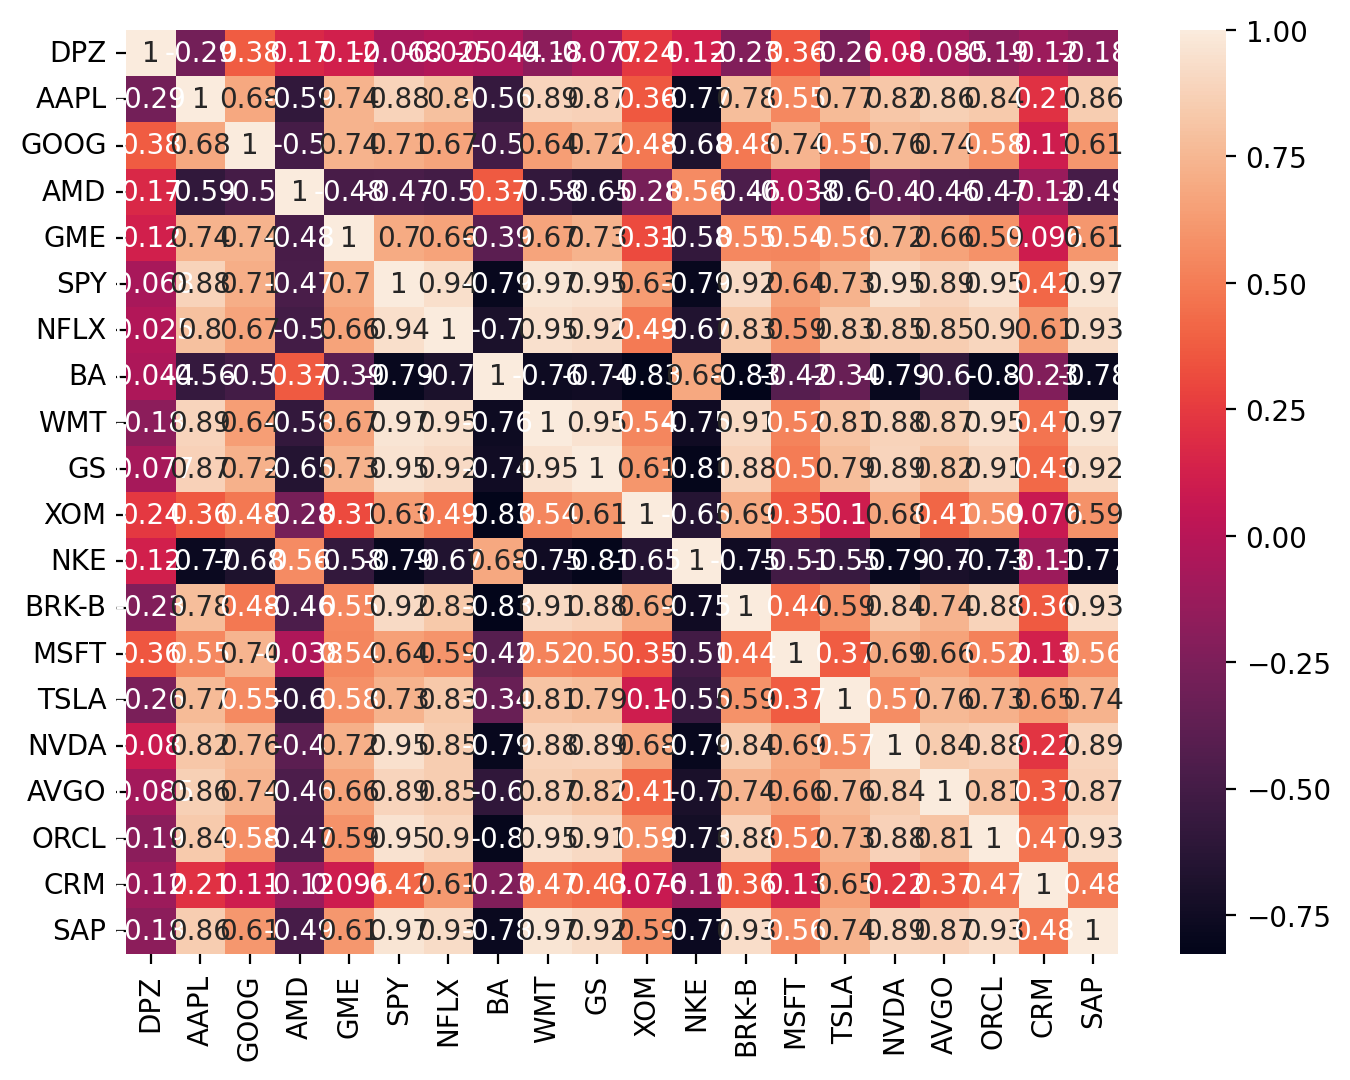

In [135]:
# heatmap to see the correlation between each company easier
figure(figsize=(8, 6), dpi=200)
sn.heatmap(corr_matrix, annot = True)

In [136]:
def find_high_corr_pairs(historical_data, corr_threshold=0.8, value_diff_threshold=0.01):
    """
    Identifies highly correlated stock pairs from historical data based on a correlation threshold
    and ensures their values are similar enough to intersect at some points.

    Parameters:
        historical_data (pd.DataFrame): DataFrame containing stock prices with columns as stock tickers.
        corr_threshold (float): Threshold above which correlation is considered high (default is 0.9).
        value_diff_threshold (float): Maximum allowed relative difference between stock prices to consider them intersecting (default is 0.01, i.e., 1%).

    Returns:
        pd.DataFrame: DataFrame containing stock pairs with correlation above the threshold and similar values.
    """
    # Calculate the correlation matrix
    corr_matrix = historical_data.corr()

    # Find high-correlation pairs
    high_corr_pairs = []
    for stock1 in corr_matrix.columns:
        for stock2 in corr_matrix.columns:
            if stock1 != stock2 and corr_matrix.loc[stock1, stock2] > corr_threshold:
                # Check if the stocks have intersecting or close values
                stock1_values = historical_data[stock1]
                stock2_values = historical_data[stock2]
                close_values = (abs(stock1_values - stock2_values) / ((stock1_values + stock2_values) / 2)) < value_diff_threshold
                if close_values.any():
                    high_corr_pairs.append((stock1, stock2, corr_matrix.loc[stock1, stock2]))

    # Remove duplicate pairs (e.g., (A, B) and (B, A))
    unique_high_corr_pairs = list(set(tuple(sorted(pair[:2])) + (pair[2],) for pair in high_corr_pairs))

    # Convert to a DataFrame for better display
    high_corr_pairs_df = pd.DataFrame(unique_high_corr_pairs, columns=["Stock 1", "Stock 2", "Correlation"])
    high_corr_pairs_df = high_corr_pairs_df.sort_values(by="Correlation", ascending=False)

    return high_corr_pairs_df

high_corr_pairs_df = find_high_corr_pairs(historical_data)
display(high_corr_pairs_df)

,Stock 1,Stock 2,Correlation
6,GS,SPY,0.952945
7,NFLX,SPY,0.936828
4,BRK-B,GS,0.881736
2,NVDA,WMT,0.879480
5,NVDA,ORCL,0.876157
3,AAPL,AVGO,0.864921
1,AAPL,SAP,0.855886
0,AVGO,ORCL,0.810588


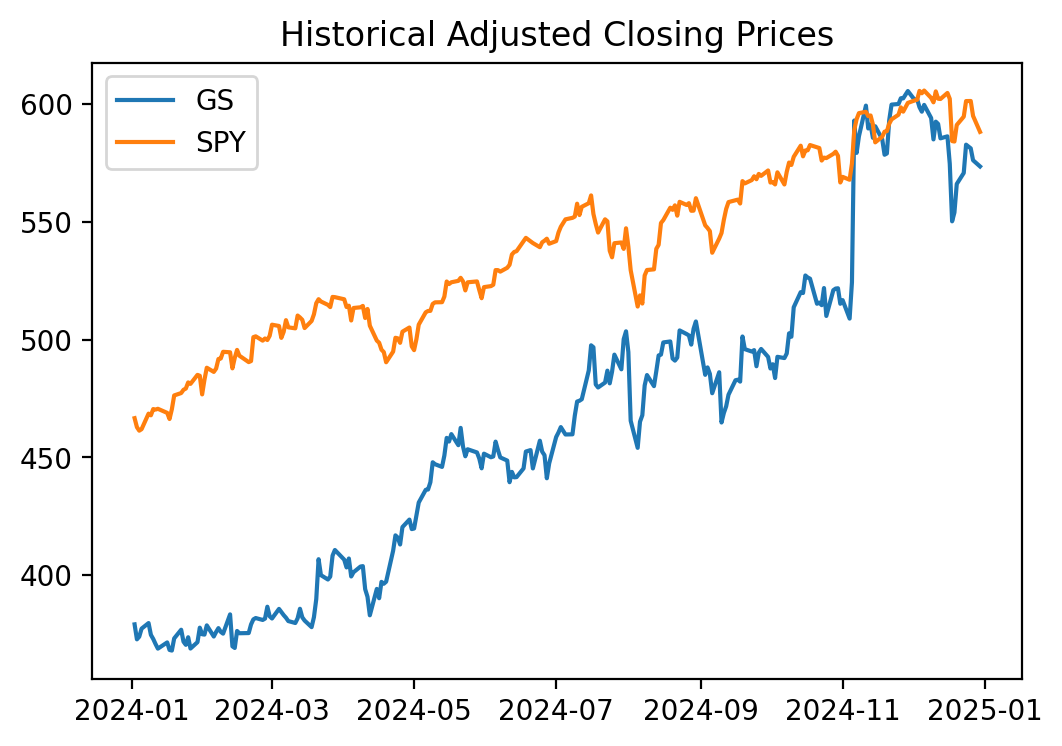

In [137]:
# After plotting different pairs, we can see that the correlation between GS and SPY is high, as well as their values are similar.

figure(figsize=(6, 4), dpi=200) 
GS = historical_data['GS'] # Goldman Sachs
SPY = historical_data['SPY'] # S&P 500
plt.plot(GS, label = "GS")
plt.plot(SPY, label = "SPY")
plt.title('Historical Adjusted Closing Prices')
plt.legend()

Text(0.5, 1.0, 'Spread between GS and SPY')

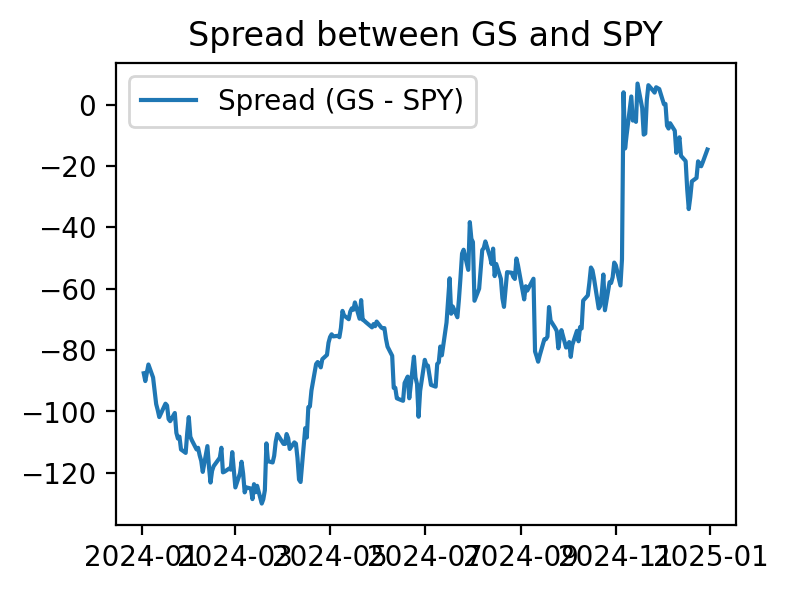

In [138]:
# plot the spread
figure(figsize=(4, 3), dpi=200)
plt.plot(GS - SPY, label = 'Spread (GS - SPY)')
plt.legend()
plt.title("Spread between GS and SPY")

In [139]:
# Augmented Engle-Granger two-step cointegration test

result = ts.coint(GS, SPY)

# Cointegration test: A technique used to find a potential correlation in a long term time series
# Determines if the spread between the two assets are constant over time.
# Null Hypothesis: Spread between series are non-stationary, occurs if p value < .05

cointegration_t_statistic = result[0]
p_val = result[1]
critical_values_test_statistic_at_1_5_10 = result[2]
print('P value for cointegration test: ', p_val)

P value for cointegration test:  0.0449160316005764


Text(0.5, 1.0, 'Price Ratio between GS and SPY')

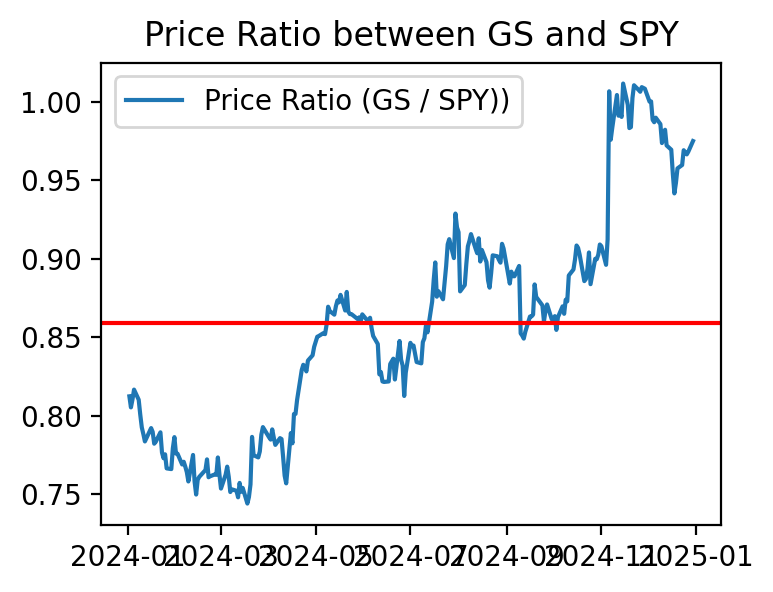

In [140]:
# take a look at the price ratios between the two time series.
figure(figsize=(4, 3), dpi=200)
ratio = GS / SPY
plt.plot(ratio, label = 'Price Ratio (GS / SPY))')
plt.axhline(ratio.mean(), color='red')
plt.legend()
plt.title("Price Ratio between GS and SPY")

### With our chosen stocks, use our trading algorithm
- create moving averages
- using MA and price ratio, find when to buy and sell

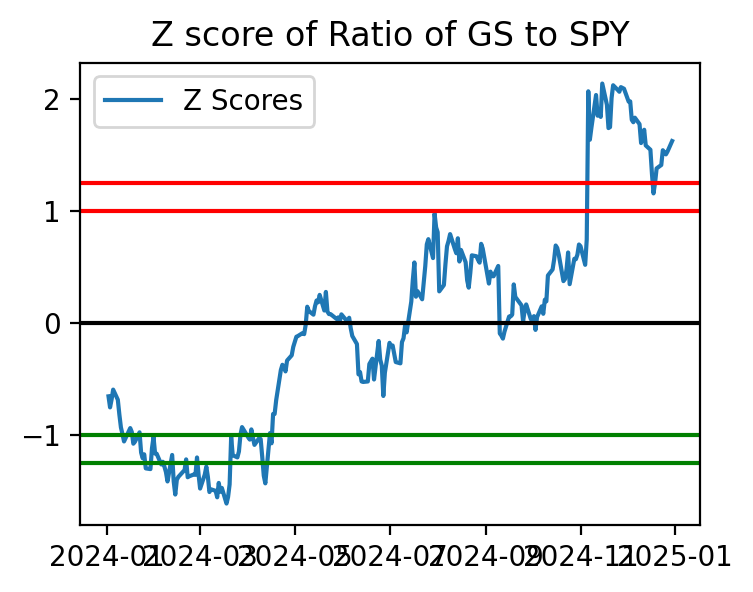

In [144]:
# standardize the ratio so we can have a upper and lower bound to help evaluate our trends
figure(figsize=(4, 3), dpi=200)
# Calculate the Zscores of each row.
df_zscore = (ratio - ratio.mean())/ratio.std()
plt.plot(df_zscore, label = "Z Scores")
plt.axhline(df_zscore.mean(), color = 'black')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Ratio of GS to SPY')
plt.show()
# Generally, the range that exists outside of these bands must come converge back to the mean. Thus, we can 
# determine when you can go long or short the pair.

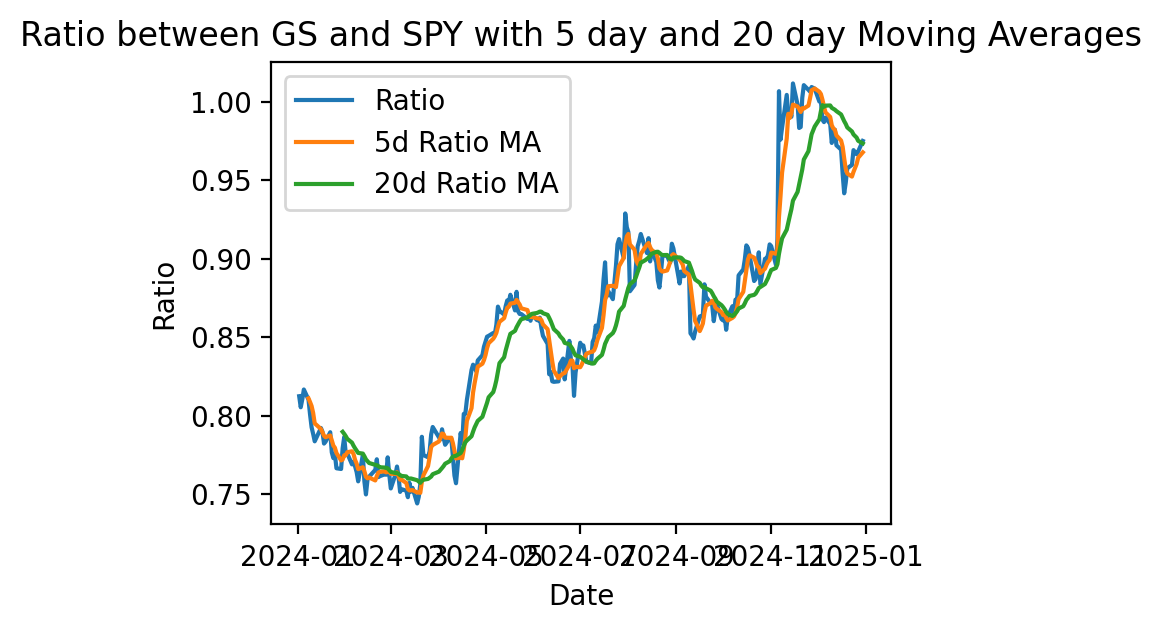

In [145]:
# 5 day and 20 day moving averages
# The 5 day moving average is more reactive to the price changes, while the 20 day moving average is more stable.

figure(figsize=(4, 3), dpi=200)
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg20 = ratio.rolling(window=20, center=False).mean()
std_20 = ratio.rolling(window=20, center=False).std()
zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg20.index, ratios_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '20d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Ratio between GS and SPY with 5 day and 20 day Moving Averages')
plt.show()

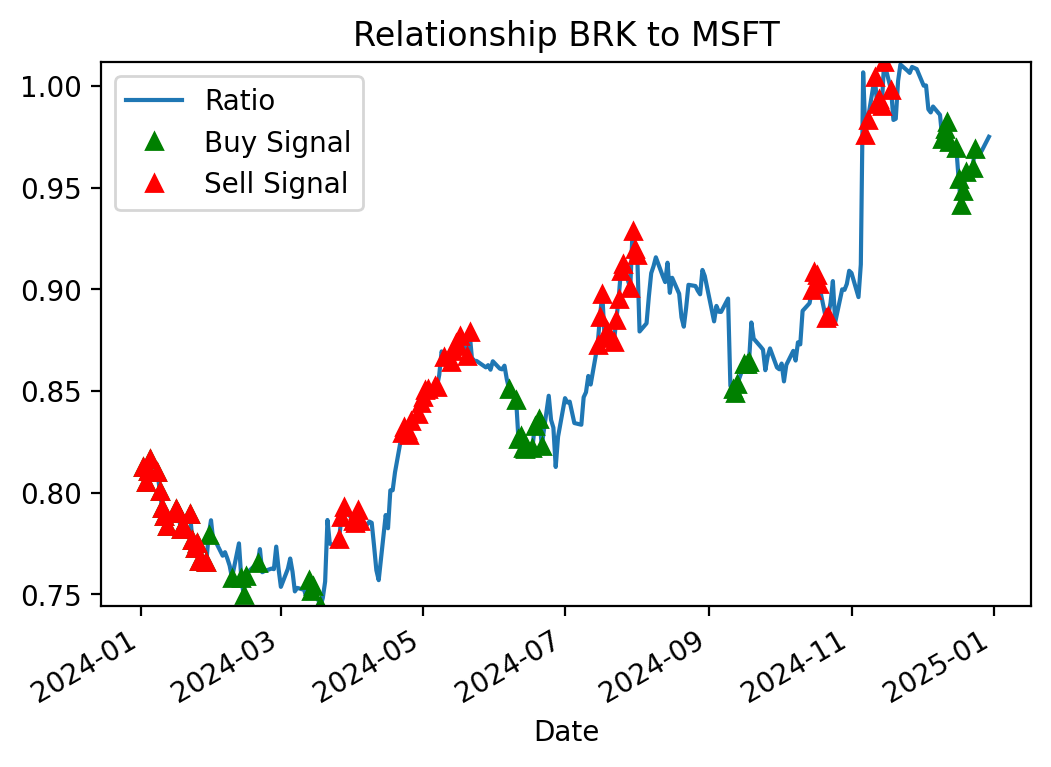

In [150]:
figure(figsize=(6, 4), dpi=200)
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_20_5>-1] = 0
sell[zscore_20_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship BRK to MSFT')
plt.show()

### Error
- not totally constant, check other tests

In [ ]:
from statsmodels.tsa.stattools import adfuller
# Compute the ADF test 
# With all time series, you want to have stationary data otherwise our data will be very hard to predict.
GS_ADF = adfuller(GS)
print('P value for the Augmented Dickey-Fuller Test is', GS_ADF[1])
SPY_ADF = adfuller(SPY)
print('P value for the Augmented Dickey-Fuller Test is', SPY_ADF[1])
Spread_ADF = adfuller(GS - SPY)
print('P value for the Augmented Dickey-Fuller Test is', Spread_ADF[1])
Ratio_ADF = adfuller(GS / SPY)
print('P value for the Augmented Dickey-Fuller Test is', Ratio_ADF[1])

# Results: can only claim stationary for the spread (since P value < 0.05). This suggests a constant mean over time.

P value for the Augmented Dickey-Fuller Test is 0.8645288028139848
P value for the Augmented Dickey-Fuller Test is 0.606451826207224
P value for the Augmented Dickey-Fuller Test is 0.8673304869442984
P value for the Augmented Dickey-Fuller Test is 0.8866942858454001
